In [537]:
import pywt
print(pywt.wavelist(kind='continuous'))
print(pywt.wavelist('mexh'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']
['mexh']


In [538]:
wavelet = pywt.DiscreteContinuousWavelet('coif11')
print(wavelet)

Wavelet coif11
  Family name:    Coiflets
  Short name:     coif
  Filters length: 66
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


In [539]:
def roll(a, size, dx=1):
    shape = a.shape[:-1] + (int((a.shape[-1] - size) / dx) + 1, size)
    strides = a.strides + (a.strides[-1] * dx,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def embed(v, min_v, max_v, dim):
    """Возвращает бинарный вектор, длины dim"""
    step_size = dim / (max_v - min_v)
    v = max(min_v, min(max_v - 0.000001, v))
    n = int((v - min_v) * step_size)
    # result = np.zeros(dim, dtype="float32")
    result = np.full(dim, 0, dtype="float32")
    result[n] = 1
    return result

def unembed(n: int, min_v: float, max_v: float, dim: int) -> float:
    step_size = float((max_v - min_v) / dim)
    v = min_v + n * step_size
    return v

100%|██████████| 185/185 [00:00<00:00, 2111.26it/s]


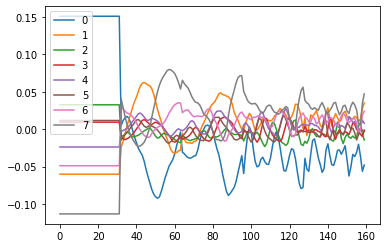

<function matplotlib.pyplot.show(*args, **kw)>

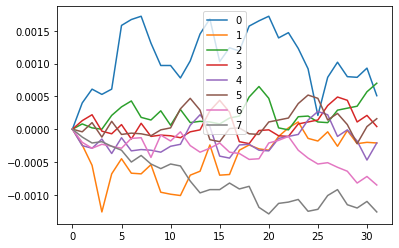

In [540]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

def load_dataset(tsv_file, count=1000, skip=0):
    stride = 1  # шаг "нарезки" входных данных
    in_shape = (32,1)
    out_shape = (8,)
    out_size = 8
    forward = 4
    data = pd.read_csv(
        tsv_file,
        sep="\t",
        header=0,
        dtype={
            "open": np.float32,
            "close": np.float32,
            "tickvol": np.float32,
            "vol": np.float32,
        },
        names=[
            "date",
            "time",
            "open",
            "high",
            "low",
            "close",
            "tickvol",
            "vol",
            "spread",
        ],
    )
    if skip > len(data.index):
        print(f"Число skip больше числа строк данных: {skip}>{len(data.index)}")
        return None, None
    if count + skip > len(data.index):
        count = len(data.index) - skip
    if skip == 0 and count == 0:
        open_rates = data["open"]
        vol_rates = data["tickvol"]
    elif skip == 0:
        open_rates = data["open"][-count:]
        vol_rates = data["tickvol"][-count:]
    elif count == 0:
        open_rates = data["open"][:-skip]
        vol_rates = data["tickvol"][:-skip]
    else:
        open_rates = data["open"][-count - skip : -skip]
        vol_rates = data["tickvol"][-count - skip : -skip]
    volumes = np.nan_to_num(np.array(vol_rates))
    volumes_strided = roll(volumes[:-forward], in_shape[0], stride)
    prices = np.nan_to_num(np.array(open_rates), posinf=0, neginf=0)
    prices_strided = roll(prices[:-forward], in_shape[0], stride)
    prices_diff = np.diff(prices)
    data_size = len(prices_strided)
    forward_prices = roll(prices_diff[in_shape[0] :], forward, stride).sum(axis=1)
    x_std = float(prices_strided.std())
    y_std = float(forward_prices.std())    
    # убираем все лишние примеры из обучающей выборки
    n = np.arange(data_size - 1)
    rnd = np.random.random(data_size - 1)
    idx = n[
        (forward_prices >= y_std)
        | (forward_prices <= -y_std)
        | (rnd <= 0.01)
    ]
    prices_strided = prices_strided[idx]
    forward_prices = forward_prices[idx]
    data_size = len(prices_strided) - in_shape[0] - in_shape[1] - forward
    wavelet_len = pywt.swt_max_level(in_shape[0])*in_shape[0]
    x = np.ndarray(shape=(data_size, wavelet_len, 1))
    y = np.zeros((data_size, out_shape[0]))
    for i in tqdm(range(data_size)):
        coeff = pywt.swt(
                prices_strided[i] - prices_strided[i][0],
                # wavelet="rbio6.8",
                # wavelet="db8",
                # wavelet="coif10",
                wavelet="db2",
                # mode="zero",
                trim_approx=True,
                norm=False
            )    
        x[i, :, 0] = pywt.coeffs_to_array(coeff)[0][:wavelet_len]
        shift = in_shape[0]
        y[i] = embed(prices[i + shift + forward] - prices[i + shift], -2*y_std, 2*y_std, out_size)
    # v = v[idx]
    return x.astype("float32"), y.astype("float32"), prices_strided.astype("float32")  # , v.astype("float32")
    
x, y, prices_strided = load_dataset(tsv_file="datas/EURUSD_M5_20000103_20200710.csv",count=1024,skip=np.random.randint(0,2**17))
in_shape = (32,1)
wavelet_len = pywt.swt_max_level(in_shape[0])*in_shape[0]
for i in range(0, 8):
    norm = tf.keras.layers.LayerNormalization()
    data = tf.constant(x[i,:,0], dtype=tf.float32)
    output = norm(data).numpy() #.reshape((wavelet_len//in_shape[0], in_shape[0])) 
    plt.plot(np.arange(len(output)),output,label=str(i))
plt.legend()
plt.show()

for i in range(0, 8):
    norm = tf.keras.layers.LayerNormalization()
    orig_data = prices_strided[i] - prices_strided[i][0]
    orig_output = norm(orig_data).numpy()
    plt.plot(np.arange(len(orig_output)),orig_data,label=str(i))

plt.legend()
plt.show